# Análisis e interpretación de Datos

###Actividad Grupal: Definición de modelos estadísticos.

##Objetivo

Analizar la información referente al desarrollo de la pandemia en México y Perú, para determinar si los procesos de vacunación tienen o no un efecto positivo en la disminución de defunciones. Así como analizar si las reestricciones impuestas por los gobiernos de cada país tuvieron un impacto en la reducción de contagios o muertes.

La información utilizada para este análisis, se encuentra en el repositorio público "COVID-19 Dataset by Our World in Data",el cual mantiene información actualizada de diferentes países.

In [1]:
#@title Importar bibliotecas y lectura de fuente de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
globalcovid = pd.read_csv(url, index_col=0)

Dado que este análisis es solo para comparar el comportamiento entre México y Perú, únicamente se filtra la información para estos paises, se crean datos como el "Año", "Mes" y "Semana" para poder agrupar por estos campos y se obtienen solo los campos a analizar. 

En este caso se agrupa la información por país, año y semana para segmentar la información.

In [38]:
#@title Limpieza y transformación
#Filtrar por paises
searchcountries = ['Peru', 'Mexico']

mexpercovid = globalcovid[['location', 'date', 'population', 'total_cases',
                           'new_cases', 'total_deaths', 'new_deaths', 
                           'total_vaccinations', 'people_vaccinated', 
                           'people_fully_vaccinated', 'new_vaccinations', 
                           'stringency_index', 'human_development_index']
             ].loc[globalcovid['location'].isin(searchcountries)]

#Convertir a fecha y contruir campos para agrupaciones
mexpercovid['date'] = pd.to_datetime(mexpercovid['date'])
mexpercovid[['population', 'total_cases', 'new_cases', 'total_deaths', 
             'new_deaths', 'total_vaccinations', 'people_vaccinated', 
             'people_fully_vaccinated', 'new_vaccinations']] = mexpercovid[['population', 
             'total_cases', 'new_cases', 'total_deaths', 
             'new_deaths', 'total_vaccinations', 'people_vaccinated', 
             'people_fully_vaccinated', 'new_vaccinations']].fillna(0).astype(int)
mexpercovid['year'], mexpercovid['month'], mexpercovid['week'] = mexpercovid['date'].dt.year, mexpercovid['date'].dt.month, mexpercovid['date'].dt.isocalendar().week

#Obtener únicamente los campos utilizados en este análisis, agrupados por país, año
covidrestmex = mexpercovid.groupby(['location', 'year', 'week']).agg({'stringency_index': 'max', 'new_cases':'sum','new_deaths':'sum', 'new_vaccinations': 'sum'}).reset_index()

covidrestmex = covidrestmex.replace(0, np.NaN)

#Normalización de valores
x = covidrestmex[['new_cases', 'new_deaths', 'new_vaccinations']].values #returns a numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
df.rename(columns = {0: 'Activos', 1: 'Defunciones', 2: 'Vacunados'}, inplace=True)
df

covidrestmex = pd.concat([covidrestmex, df], axis=1)

In [48]:
#@title Dataframe Resultado:
covidrestmex

,location,year,week,stringency_index,new_cases,new_deaths,new_vaccinations,Activos,Defunciones,Vacunados
0,Mexico,2020,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Mexico,2020,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mexico,2020,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Mexico,2020,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Mexico,2020,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
217,Peru,2022,1,68.52,73135.0,285.0,1978382.0,0.215083,0.031726,0.206886
218,Peru,2022,2,68.52,230313.0,397.0,1556092.0,0.677339,0.044283,0.162620
219,Peru,2022,3,68.52,340025.0,859.0,952317.0,1.000000,0.096076,0.099329
220,Peru,2022,4,57.41,214581.0,789.0,201562.0,0.631072,0.088229,0.020631


In [44]:
#@title Crear un dataframe por cada país
#Filtrar datasets por país y año
covidrestmex1 = covidrestmex.loc[(covidrestmex['location'] == 'Mexico') & (covidrestmex['year'] == 2021) & (covidrestmex['week'] != 53)]
covidrestper = covidrestmex.loc[(covidrestmex['location'] == 'Peru') & (covidrestmex['year'] == 2021) & (covidrestmex['week'] != 53)]
covid2021 = covidrestmex.loc[(covidrestmex['year'] == 2021) & (covidrestmex['week'] != 53)]

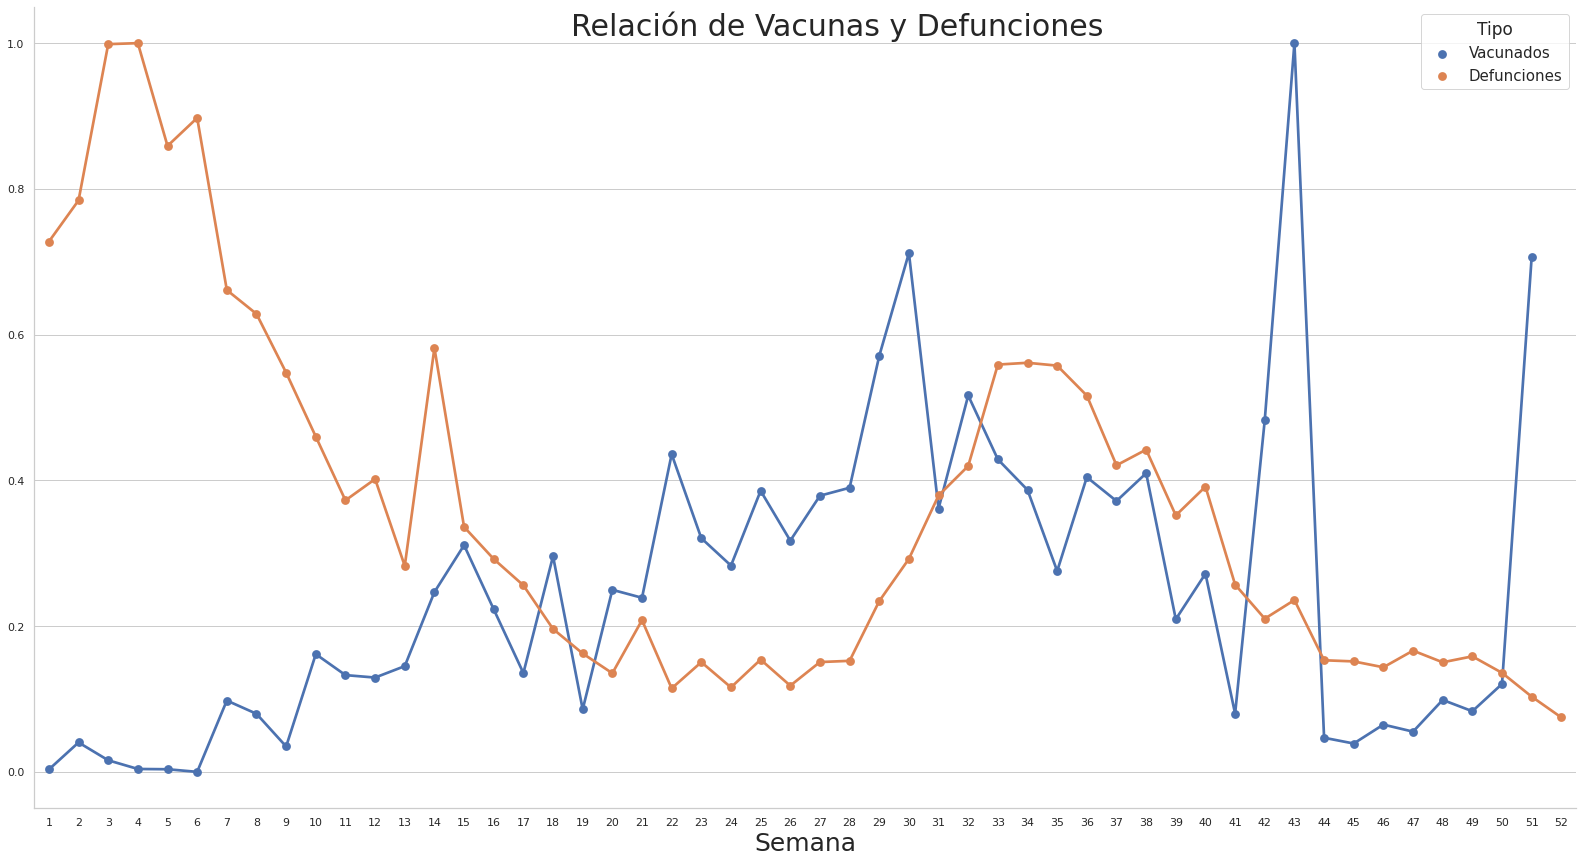

In [92]:
#@title Texto de título predeterminado
dfm = covidrestmex1[['week', 'Vacunados', 'Defunciones']].melt('week', var_name='cols', value_name='vals')

dfm.rename(columns = {'week': 'Semana', 'cols': 'Tipo'}, inplace=True)
sns.set_style("whitegrid")
g = sns.catplot(x="Semana", 
                y="vals", 
                hue='Tipo', 
                data=dfm, 
                kind='point',
                height=12, aspect=15/8)
g.set_axis_labels("Semana", "", fontsize=25)
g.fig.suptitle('Relación de Vacunas y Defunciones', fontsize=30)
g._legend.remove()

plt.legend(title='Tipo', fontsize='15', title_fontsize='17')

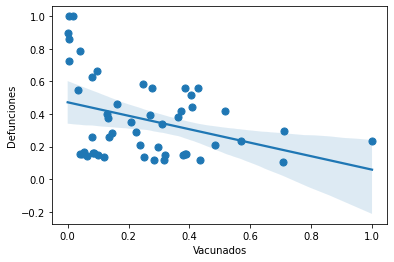

In [47]:
sns.regplot(x="Vacunados", y="Defunciones", data=covidrestmex1, x_estimator=np.mean);

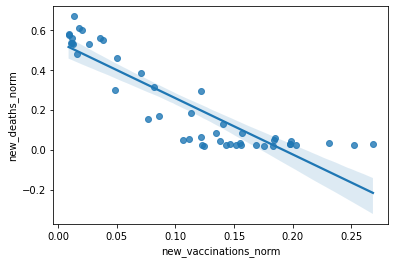

In [12]:
sns.regplot(x="Vacunados", y="Defunciones", data=covidrestper);

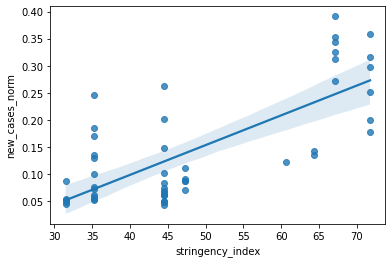

In [13]:
sns.regplot(x="stringency_index", y="Activos", data=covidrestmex1);

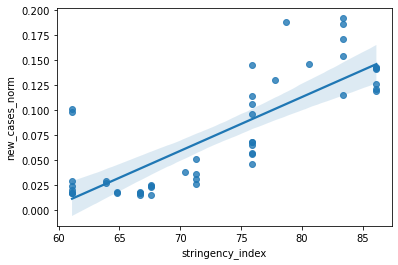

In [14]:
sns.regplot(x="stringency_index", y="new_cases_norm", data=covidrestper);

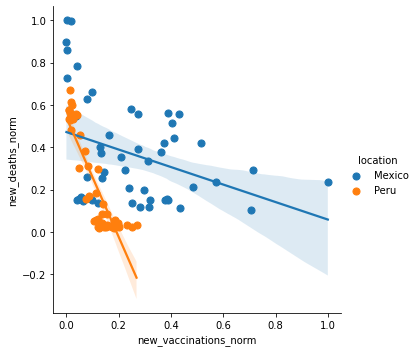

In [15]:
sns.lmplot(x="new_vaccinations_norm", y="new_deaths_norm", data=covid2021, x_estimator=np.mean, hue='location');

In [10]:
mexpercovid.groupby(['location', 'year', 'month']).agg({'new_cases':'sum','new_deaths':'sum', 'new_vaccinations': 'sum'}).to_csv('mexpercovid.csv')